In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [3]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [4]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

# Trying out different input_len and horizon
input_len = 32
horizon = 14

In [5]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [6]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)

Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

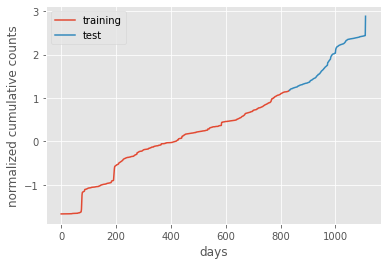

In [7]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    # train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    train_test_split=0.75, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

In [8]:
features

,depth_mean,depth_std,easting_mean,easting_std,northing_mean,northing_std,magnitude_mean,magnitude_std,pressure,dpdt,seismic
0,1911.542213,0.000000,337462.383000,0.000000,4.415647e+06,0.000000,-1.740000,0.000000,8.599065e+06,0.017439,1.0
1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.601838e+06,0.018007,1.0
2,1898.448644,0.000000,337552.609000,0.000000,4.416203e+06,0.000000,-1.810000,0.000000,8.604612e+06,0.018575,2.0
3,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.607385e+06,0.019143,2.0
4,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.610158e+06,0.019711,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1106,2014.708168,88.488599,337748.769500,708.086158,4.416369e+06,696.820946,-1.245000,0.104722,8.652984e+06,-0.029754,4886.0
1107,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.649775e+06,-0.030196,4886.0
1108,2020.795489,32.663965,337981.979333,628.363621,4.416724e+06,294.071551,-1.110000,0.117898,8.646565e+06,-0.030638,4889.0
1109,2058.649802,0.000000,338095.812000,0.000000,4.416600e+06,0.000000,-1.490000,0.000000,8.643355e+06,-0.031079,4890.0


### Model Architecture

In [9]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [10]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [11]:

from tqdm.notebook import tqdm

In [12]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [13]:
# print Huber Loss
test_loss_vals

[0.3284794054925442,
 0.10092476336285472,
 0.05057495250366628,
 0.037087312201038,
 0.023135350551456213,
 0.01690775153110735,
 0.018485178879927844,
 0.012380889849737287,
 0.009121569004491903,
 0.007941927542560734,
 0.006898187435581349,
 0.006737486983183771,
 0.006676777251414023,
 0.004605671550962143,
 0.0038351995826815255,
 0.004250147016136907,
 0.0036700046694022603,
 0.0033475243326392956,
 0.0030194702485459857,
 0.0030018403122085147,
 0.00242602599246311,
 0.002485240449459525,
 0.002787468063615961,
 0.0026581796482787468,
 0.0021564925409620628,
 0.0021475879548233934,
 0.002203567051765276,
 0.0017018367288983427,
 0.0016722191867302172,
 0.0016993910176097415,
 0.0019007811533811036,
 0.0017441463278373703,
 0.0017706030012050178,
 0.0016052334649430122,
 0.0015606946726620663,
 0.001650235764827812,
 0.0016218888958974276,
 0.0016434993831353495,
 0.0014496823896479327,
 0.0013068934240436647,
 0.0013262599877634784,
 0.00129822072085517,
 0.001334200087512727,


Text(0.5, 0, 'Epoch')

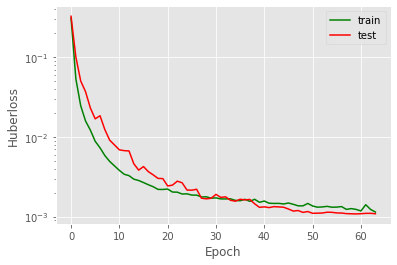

In [14]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.legend()
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

Visualize the forecast

In [15]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]


In [21]:
def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

In [22]:
model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

In [23]:
samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

In [24]:
sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

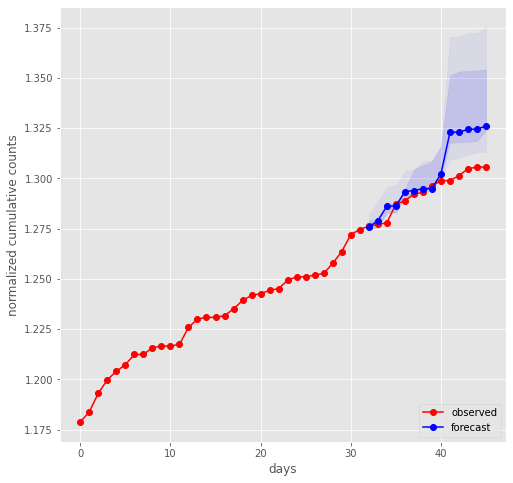

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()

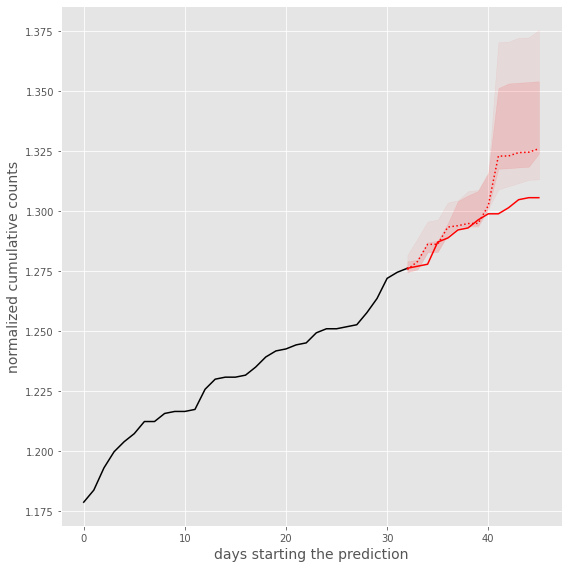

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'k')
ax.plot(np.arange(end_input, end_output), output_y, 'r',)
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='r')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='r')
ax.plot(np.arange(end_input, end_output), pred_y, ':r')
plt.xlabel('days starting the prediction',fontsize=14)
plt.ylabel('normalized cumulative counts',fontsize=14)
plt.tight_layout()
